<a href="https://colab.research.google.com/github/lin3372/252_ML.tutorial/blob/main/RL/03_Hands_on_RL_Tabular_SARSA_220801.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Hands-On Reinforcement Learning Course: Part 3 - Tabular SARSA](https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-3-5db40e7938d4)

by [Pau Labarta Bajo](https://pau-labarta-bajo.medium.com/?source=post_page-----269b50e39d08--------------------------------), Dec 17, 2021.  [[github repo for this lesson]](https://github.com/Paulescu/hands-on-rl)

Summarized and Revised by Ivan H.P. Lin

In [part 2](https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-2-1b0828a1046b) , [Ivan's colab](https://colab.research.google.com/drive/1Dn2cWuBFIG1rO8h3d92jSqDFiQW5RvLj?usp=sharing) we implemented discrete Q-learning to train an agent in the Taxi-v3 environment.

Today, we are going one step further to solve the MountainCar environment 🚃 using **SARSA** algorithm.

All the code for this lesson is in [this Github repo](https://github.com/Paulescu/hands-on-rl). Git clone it to follow along with today’s problem.

<img src="https://miro.medium.com/max/1050/1*Aef4_9CUysYfv18dulK5uw.jpeg" width="30%">

# 0. Contents

1. The Mountain car problem 🚃
2. Environment, actions, states, rewards
3. Random agent baseline 🚃🍷
4. SARSA agent 🚃🧠
5. Take a pause and breath ⏸🧘
6. Recap ✨
7. Homework 📚
8. What’s next? ❤️

#1.. The Mountain car problem 🚃

The Mountain Car problem is an environment where gravity exists and the goal is to help a poor car win the battle against it.

The car needs to escape the valley where it got stuck. The car’s engine is not powerful enough to climb up the mountain in a single pass, so the only way to make it is to drive back and forth and build sufficient momentum.

<figure><center>
<img src="https://miro.medium.com/max/375/1*Ysl6O2aFOLmZLoyGg2zkMQ.gif" width="30%"><figcaption>Episode 2</figcaption>
<img src="https://miro.medium.com/max/375/1*cC5nAn_WU0GYjT9Pvd2g4A.gif" width="30%"><figcaption>Episode 200</figcaption>
</center></figure>

The video you just saw corresponds to the SarsaAgent we will build today.






### Why this problem?
The philosophy of this course is to progressively add complexity. Step-by-step.

Today’s environment represents a small but relevant increase in complexity when compared to the ```Taxi-v3``` environment from [part 2(ivan's colab)](https://colab.research.google.com/drive/1Dn2cWuBFIG1rO8h3d92jSqDFiQW5RvLj?usp=sharing).

But, what exactly is harder here?

As we saw in [part 2(ivan's colab)](https://colab.research.google.com/drive/1Dn2cWuBFIG1rO8h3d92jSqDFiQW5RvLj?usp=sharing), the difficulty of a reinforcement learning problem is directly related to the size of

* the **action space**: 
  - how many actions can the agent choose from at each step?
* the **state space**: 
  - in how many different environment configurations can the agent find itself?

For small environments with a finite (and small) number of actions and states, we have strong guarantees that algorithms like **Q-learning** will work well. These are called **tabular** or **discrete environments**.



**$Q$-functions**:
* essentially matrices with as many ***rows as states*** and ***columns as actions***. 
  - In these small worlds, our agents can easily explore the states and build effective policies. 
* As the state space and (especially) the action space becomes larger, the RL problem becomes harder to solve.

Today’s environment is NOT tabular. However, we will use a discretization “trick” to transform it into a tabular one, and then solve it.

Let’s first get familiar with the environment!

#2.. Environment, actions, states, rewards 👉🏽 
[notebooks/00_environment.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/02_mountain_car/notebooks/00_environment.ipynb)



👉Before you solve a Reinforcement Learning problem you need to define what are
  - the actions
  - the states of the world
  - the rewards

👉We are using the ```MountainCar-v0``` environment from [OpenAI's gym](https://gym.openai.com/envs/MountainCar-v0/)

👉```MountainCar-v0``` is still an easy environment, but harder than ```Taxi-v3```, which we solved in [part 1](https://github.com/Paulescu/hands-on-rl/tree/main/01_taxi) of the course.

👉```MountainCar-v0``` is not a tabular environment (i.e. **tabular** = finite number of actions and states), but with a small trick it can become one. This is why I say it is still an easy environment.

### display setup for colab
reference stackoverflow - [How to render OpenAI gym in google Colab? ](https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab)

In [1]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
# then import all your libraries, including *matplotlib* & *ipythondisplay*:

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

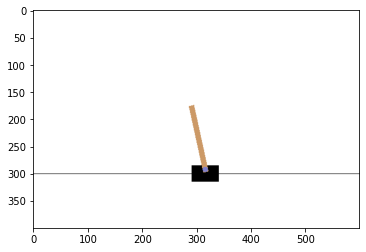

In [5]:
## last but not least, using gym's "rgb_array" render functionally, 
## render to a "Screen" variable, then plot the screen variable using Matplotlib! 
## (rendered indirectly using Ipython display)

## Example code for display in colab
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(10):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

### download util files from github

In [6]:
import os
user = "Paulescu"
repo = "hands-on-rl"
src_dir = "02_mountain_car/src"
pyfiles = ["base_agent.py", "config.py", "loops.py", "momentum_agent.py", "random_agent.py", "sarsa_agent.py"]
### Note - For "viz.py" there is an error in get_action(), so I fixed it and put in my respoitory =, needs to download tehe viz.py from my github repository

curr_dir=os.getcwd()
os.makedirs('src', exist_ok=True)

os.chdir('src')

for f_rl in pyfiles:
  url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{f_rl}"
  !wget --no-cache --backups=1 {url}

##########################   
user = "lin3372"
repo = "252_ML.tutorial"
src_dir = "RL/src/02_mountain_car/src"
pyfiles = ["viz.py"]

for f_rl in pyfiles:
  url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{f_rl}"
  !wget --no-cache --backups=1 {url}

os.chdir(curr_dir)

--2022-08-04 06:49:41--  https://raw.githubusercontent.com/Paulescu/hands-on-rl/main/02_mountain_car/src/base_agent.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 706 [text/plain]
Saving to: ‘base_agent.py’

base_agent.py       100%[===================>]     706  --.-KB/s    in 0s      

2022-08-04 06:49:41 (27.8 MB/s) - ‘base_agent.py’ saved [706/706]

--2022-08-04 06:49:41--  https://raw.githubusercontent.com/Paulescu/hands-on-rl/main/02_mountain_car/src/config.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225 [text/pla

## Load the environment 🌎, and Plot it 🎨

In [7]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
%matplotlib inline
##from IPython import display

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['info', 'display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
import gym
env = gym.make('MountainCar-v0')

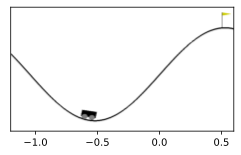

In [9]:
# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
env.reset()
frame = env.render(mode='rgb_array')

fig, ax = plt.subplots(figsize=(4, 3))
ax.axes.yaxis.set_visible(False)
ax.imshow(frame, extent=[env.min_position, env.max_position, 0, 1])

## **Action space**

0. Accelerate to the left
1. Do nothing
2. Accelerate to the right

In [10]:
print("Action Space {}".format(env.action_space))

Action Space Discrete(3)


## **State space**

Two numbers determine the state of the car:
- Its **position**, which ranges $[-1.2, 0.6]$
- Its **speed**, which ranges from $[-0.07, 0.07]$.

The state is given by 2 continuous numbers. This is a remarkable difference with respect to the ```Taxi-v3``` environment from [part 2](https://colab.research.google.com/drive/1Dn2cWuBFIG1rO8h3d92jSqDFiQW5RvLj?usp=sharing). We will later see how to handle this.

In [11]:
# The state consists of 2 numbers:
# - Car's position, from -1.2 to 0.6
# - Car's velocity, from -0.07 to 0.07
print("State Space {}".format(env.observation_space))

print(f'Position ranges from {env.min_position} to {env.max_position}')
print(f'Velocity ranges from {-env.max_speed} to {env.max_speed}')

State Space Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Position ranges from -1.2 to 0.6
Velocity ranges from -0.07 to 0.07


## **Rewards**
* A reward of $-1$ is awarded if the position of the car is less than $0.5$.

* The episode ends once the car's position is above $0.5$, or the max number of steps has been reached: ```n_steps >= env._max_episode_steps```

A default negative reward of $-1$ encourages the car to escape the valley as fast as possible.

In general, I recommend you check [Open AI Gym environments’](https://github.com/openai/gym/tree/master/gym/envs) implementations directly in Github to understand **states**, **actions**, and **rewards**.

The code is well documented and can help you quickly understand everything you need to start working on your RL agents. [```MountainCar‘s``` implementation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py) is here, for example.

# 3.. **Random agent baseline 🚃🍷👉🏽**  
[01_random_agent_baseline.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/02_mountain_car/notebooks/01_random_agent_baseline.ipynb)

👉Before you try to solve a Reinforcement Learning problem you should get a grasp of its difficulty.

👉 To do so, you need to design a dummy agent that can peform the task without much brains, and evaluate its performance.

👉A simple way to do so is by using a Random Agent, that chooses its next action randomly, without paying attention at the current state of the environment.

Reinforcement learning problems can grow in complexity pretty easily. Well-structured code is your best ally to keep complexity under control.

Today we are going to level up our Python skills and use a ```BaseAgent class``` for all our agents. From this ```BaseAgent class```, we will derive our ```RandomAgent``` and ```SarsaAgent``` classes.

<figure><center>
<img src="https://miro.medium.com/max/542/1*7cjWWHpyER3WHBzhmoT24Q.png" width="60%">
<figcaption>Parent and child classes (Image by the author)</figcaption>
</center></figure>

## **BaseAgent**- 4 methods 
```BaseAgent``` is an abstract class we define in ```src/base_agent.py```

Two of its methods are abstract, which means we are forced to implement them when we derived our ```RandomAgent``` and ```SarsaAgent``` from the ```BaseAgent```:

* ```**get_action(self, state)**```
  - returns the action to perform, depending on the state.

* ```**update_parameters(self, state, action, reward, next_state)**```
  - adjusts agent parameters using experience. Here we will implement the **SARSA** formula.

The other two methods let us save/load the trained agent to/from the disk.

* save_to_disk(self, path)
* load_from_disk(cls, path)

As we start implementing more complex models and training times increase, it is going to be a great idea to save checkpoints during training.

### **```BaseAgent``` class**

<img src="https://miro.medium.com/max/1050/1*W6OLswy8iqO29x8hgIlNWQ.png" width="50%">

### **```BaseAgent class```** ==> **```RandomAgent```**

<img src="https://miro.medium.com/max/1050/1*NqjFJieCnYBOTPakBKMu3Q.png" width="50%">

Let’s evaluate this **```RandomAgent```** over ***```n_episodes = 100```*** to see how well it fares

## Load the Environment 🌎

In [12]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [13]:
import gym
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000

## **Random agent 🤖🍷**

In [14]:
# If this import fails, run this in your shell and relaunch jupyter:
# `export PYTHONPATH=".."`
from src.random_agent import RandomAgent
agent = RandomAgent(env)

from src.loops import evaluate
n_episodes = 100
rewards, max_positions = evaluate(agent, env, n_episodes)

100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


### Success rate is... bad, let's see how far we got in each attempt

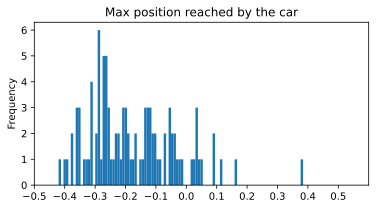

In [15]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax = plt.subplots(figsize = (6, 3))
ax.set_title("Max position reached by the car")    
ax.set(xlim=(-0.5, 0.6), xticks=np.arange(-0.5, 0.6, 0.1))
pd.Series(max_positions).plot(kind='hist', bins=100)

plt.show()


### Let's see our agent in action 🎬

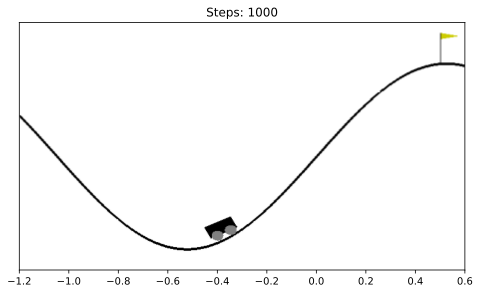

In [16]:
# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from src.viz import show_video

show_video(agent, env, sleep_sec=0.01)


# 4.. **SARSA agent** 🤖🧠 
[02_sarsa_agent.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/02_mountain_car/notebooks/02_sarsa_agent.ipynb)




**SARSA** (by Rummery and Niranjan) is an algorithm to train reinforcement learning agents by learning the optimal **$q$-value** function.

It was published in 1994, two years after [Q-learning](https://www.gatsby.ucl.ac.uk/~dayan/papers/cjch.pdf) (by Chris Walkins and Peter Dayan).

**SARSA** stands for **S**tate **A**ction **R**eward **S**tate **A**ction.

Both **SARSA** and **$Q$-learning** exploit the Bellman equation to iteratively find better approximations to the optimal **$q$-value** function **$Q^*(s, a)$**:

**$$Q^o(s,a) \rightarrow Q^1(s,a) \rightarrow Q^2(s,a) \rightarrow \cdots \rightarrow Q^N(s,a) \approx Q^*(s,a)$$**

But, **SARSA** does it slightly differently.

If you remember from [part 2](https://colab.research.google.com/drive/1Dn2cWuBFIG1rO8h3d92jSqDFiQW5RvLj?usp=sharing), the update formula for **$Q$-learning** is

<center>
<img src="https://miro.medium.com/max/1050/0*VmNvb0OaMSsBhykj.png" width="86%">
</center>

This formula is a way to compute a new estimate of the **$q$-value** that is closer to

<center>
<img src="https://miro.medium.com/max/1050/1*MlcDcVs5vRN1uM09F1EM9A.png" width="60%">
</center>

This quantity is a **target 🎯** we want to correct our old estimate towards. It’s an estimation of the optimal **$q$-value** we should aim at, that changes as we train the agent and our **$q$-value** matrix gets updated.

### **Reinforcement learning & ML & moving target**
**Reinforcement learning problems often look like supervised ML problems, but with moving targets 🏃 🎯**

**SARSA** has a similar update formula but with a different target
<center>
<img src="https://miro.medium.com/max/1050/1*Y-vKWZbWFOIpQNBDHlu-Aw.png" width="70%">
</center>

SARSA’s target:
<center>
<img src="https://miro.medium.com/max/1050/1*n9seK9X4q4KBNE7qpyidTA.png" width="40%">
</center>

depends also on the action **$a’$** the agent will take in the next state **$s’$**. This is the final **$A$** in **SARSA’s** name.

If you explore enough the state space and update your **$q$-matrices** with **SARSA** you will get to an optimal policy. Great!


### **$Q$-learning (off-policy)** vs **SARSA (on-policy)** - Key Differences

* **SARSA’s** update depends on the next action **$a^{’}$**, and hence on the current policy. As you train and the **$q$-value** (and associated policy) get updated the new policy might produce a different next action **$a^{’’}$** for the same state **$s^{’}$**. You cannot use past experiences **$(s, a, r, s^{’}, a^{’})$** to improve your estimates. Instead, you use each experience once to update the **$q$-values** and then throw it away. Because of this, **SARSA** is called an **on-policy** method.

* In **$Q$-learning**, the update formula does not depend on the next action **$a^{’}$**, but only on **$(s, a, r, s^{’})$**. You can reuse past experiences **$(s, a, r, s^{’})$**, collected with an old version of the policy, to improve the **$q$-values** of the current policy. **$Q$-learning** is an **off-policy** method.

**Off-policy** methods need less experience to learn than **on-policy** methods because you can re-use past experiences several times to improve your estimates. They are more sample efficient.

However, **off-policy** methods have issues converging to the optimal **$q$-value** function **$Q^*(s, a)$** when the state, action spaces grow. They can be tricky and unstable.

We will encounter these trade-offs later in the course when we enter the Deep RL territory 🤓.

In [17]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### Environment 🌎

In [18]:
import gym
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000

In the ```MountainCar environment```, the state is not discrete, but a pair of continuous values (position ```s1```, velocity ```s2```).

Continuous essentially means infinite possible values in this context. If there are infinite possible states, it is impossible to visit them all to guarantee that SARSA will converge.

To fix that we can use a trick.

Let’s discretize the state vector into a finite set of values. Essentially, we are not changing the environment, but the representation of the state the agent uses to choose its actions.

Our **SarsaAgent** discretizes the state ```(s1, s2)``` from continuous to discrete, by rounding the position ```[-1.2 … 0.6]``` to the closest ```0.1``` mark, and the velocity ```[-0.07 ...0.07]``` to the closest ```0.01``` mark.

<figure><center>
<img src="https://miro.medium.com/max/1575/1*VFlTdjKroJ6Qt-douDurcw.png" width="70%">
</center></figure>

Once the agent uses a discretized state, we can use the **SARSA** update formula from above, and as we keep on iterating we will get closer to an optimal **$q$-value**.

### **SARSA agent 🤖**

This is the whole implementation of the ```SarsaAgent```

<figure><center>
<img src="https://miro.medium.com/max/1575/1*PF3p91x8tGMO4dGphz9qvQ.png" width="68%">
</center></figure>

Note 👆 that the **$q$-value** function is a matrix with 3 dimensions: 
  - 2 for the state **(position, velocity)**
  - 1 for the **action**.

Let’s choose sensible hyper-parameters and train this ```SarsaAgent``` for ```n_episodes = 10,000```

<figure><center>
<img src="https://miro.medium.com/max/1575/1*hZeundcHQjXNC9zRVL8Qew.png" width="50%">
<img src="https://miro.medium.com/max/1575/1*YX_S88jawVJLzMQKU447uA.png" width="50%">
</center></figure>

In [19]:
### Define the SarsaAgent
from src.sarsa_agent import SarsaAgent

alpha = 0.1 # learning rate
gamma = 0.9 # discount factor

agent = SarsaAgent(env, alpha, gamma)

In [20]:
### Training the agent
from src.loops import train

rewards, max_positions = train(
    agent, env, n_episodes=10000, epsilon=0.1)

Epsilon: 0.10: 100%|██████████| 10000/10000 [05:48<00:00, 28.72it/s]


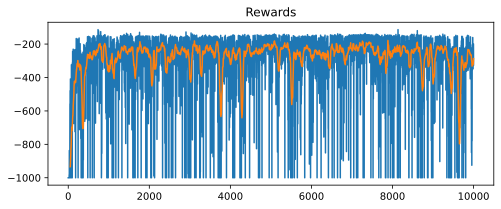

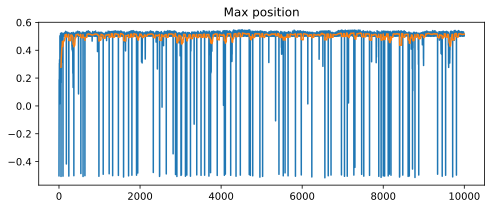

In [21]:
### Plot train metrics
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 3))
ax.set_title("Rewards")
pd.Series(rewards).plot(kind='line')
pd.Series(rewards).rolling(window=50).mean().plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (8, 3))
ax.set_title("Max position")    
pd.Series(max_positions).plot(kind='line')
pd.Series(max_positions).rolling(window=50).mean().plot(kind='line')
plt.show()


### **Evaluation**

If you observe the ```max_position``` chart above you will realize that the car occasionally fails to climb the mountain.

How often does that happen? Let’s evaluate the agent on ```1,000``` random episodes:

In [22]:
### Ecaluate the SarsaAgent for 1000 times
from src.loops import evaluate

n_episodes = 1000
eval_rewards, eval_max_positions = evaluate(
    agent, env, n_episodes)

100%|██████████| 1000/1000 [00:19<00:00, 52.14it/s]


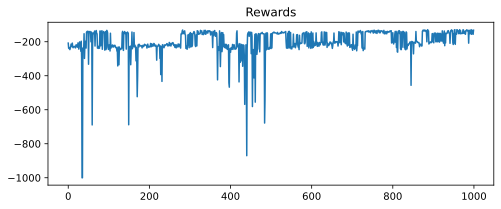

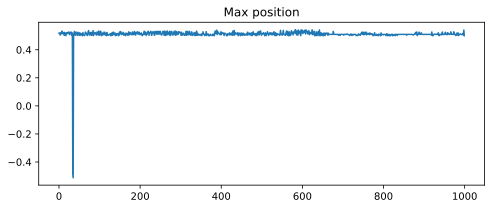

In [23]:
### Plot the Rewards and Max Position
import pandas as pd

fig, ax = plt.subplots(figsize = (8, 3))
ax.set_title("Rewards")    
pd.Series(eval_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (8, 3))
ax.set_title("Max position")    
pd.Series(eval_max_positions).plot(kind='line')
plt.show()

In [24]:
### compute the success rate of our trained SarsaAgent
n_completed = sum([1 if m > 0.5 else 0 for m in eval_max_positions])
print(f'{n_completed} success out of {n_episodes} attempts')

998 success out of 1000 attempts


### Plotting the agent's policy
👉This is the agent's **greedy** policy.

👉The **greedy policy** selects the action that maximizes the **$q$-value** function at any given state.

👉In practice you can pick an **epsilon-greedy ($\epsilon$-greedy) policy**, to avoid overfitting issues.  Refer to [part 2](https://colab.research.google.com/drive/1Dn2cWuBFIG1rO8h3d92jSqDFiQW5RvLj?usp=sharing) for **epsilon-greedy**

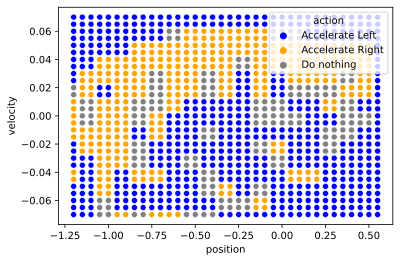

,position,velocity,action
0,-1.20,-0.070,Accelerate Left
1,-1.20,-0.065,Accelerate Left
2,-1.20,-0.060,Accelerate Left
3,-1.20,-0.055,Accelerate Left
4,-1.20,-0.050,Accelerate Left
...,...,...,...
1039,0.55,0.050,Accelerate Left
1040,0.55,0.055,Accelerate Left
1041,0.55,0.060,Accelerate Left
1042,0.55,0.065,Accelerate Left


In [25]:
from src.viz import plot_policy

positions = np.arange(env.min_position, env.max_position, 0.05)
velocities = np.arange(-env.max_speed, env.max_speed, 0.005)

plot_policy(agent, positions, velocities)


In [26]:
### Save the agent to disk 💾
from src.config import SAVED_AGENTS_DIR
path = SAVED_AGENTS_DIR / 'sarsa_agent_10k_steps'
print(f'Saving agent to {path}')
agent.save_to_disk(path)

Saving agent to /content/saved_agents/sarsa_agent_10k_steps


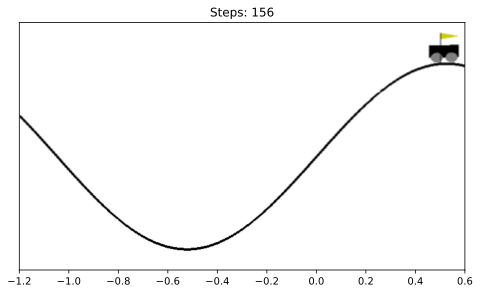

In [27]:
### See the agent in action 🎬

# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from src.viz import show_video

show_video(agent, env, sleep_sec=0.01)

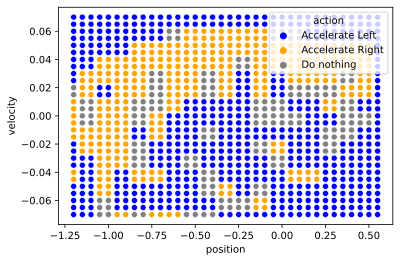

In [28]:
### plot the policy 🎨
from src.viz import plot_policy

positions = np.arange(env.min_position, env.max_position, 0.05)
velocities = np.arange(-env.max_speed, env.max_speed, 0.005)
sarsa_policy = plot_policy(agent, positions, velocities)

# 5.. The **MomentumAgent** - the best one
[03_momentum_agent_baseline.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/02_mountain_car/notebooks/03_momentum_agent_baseline.ipynb)

👉Sometimes there are easier paths than RL

👉 In the ```MountainCar environment``` the best policy is just follow the momentum:
* accelerate right, when the car is moving to the right ```velocity > 0```
* accelerate left, when the car is moving to the left ```velocity <= 0```

Visually the policy shall look like this:

<img src="https://miro.medium.com/max/1050/1*IBxzJEqZJLRR2Bts5syeEg.png" width="50%">

### Enviornment - **MomentumAgent**

In [29]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [30]:
import gym
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000

## **MomentumAgent** Definition

This is how you write this ```MomentumAgent``` in Python:

<figure><center>
<img src="https://miro.medium.com/max/1050/1*oq-v4VUolKEM4Cx5kUeCSQ.png" width="60%">

<img src="https://miro.medium.com/max/1050/1*Brb755zRjnvSDq90D93GoQ.png" width="60%">

<img src="https://miro.medium.com/max/1050/1*JQkdwAwr09MCHOyAX4ExOQ.png" width="60%">
</center></figure>

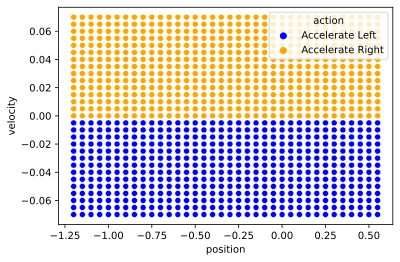

In [31]:
from src.momentum_agent import MomentumAgent

perfect_agent = MomentumAgent(env)
perfect_policy = plot_policy(perfect_agent, positions, velocities)

In [32]:
from src.momentum_agent import MomentumAgent
agent = MomentumAgent(env)

from src.loops import evaluate
n_episodes = 1000
f_epsilon = 0.1
rewards, max_positions = evaluate(agent, env, n_episodes, f_epsilon)

100%|██████████| 1000/1000 [00:05<00:00, 192.32it/s]


## Evaluation

In [33]:
### And the success rate is... great!
n_completed = sum([1 if m > 0.5 else 0 for m in max_positions])
print(f'MomentumAgent: {n_completed} success out of {n_episodes} attempts')

MomentumAgent: 1000 success out of 1000 attempts


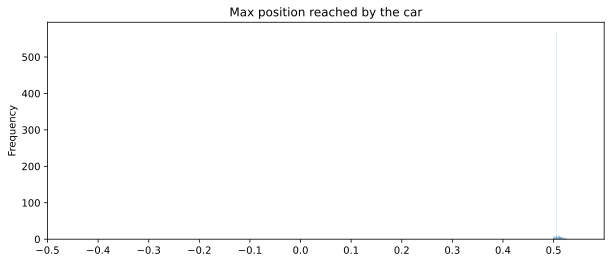

In [34]:
### Let's see how far we got in each attempt
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Max position reached by the car")    
ax.set(xlim=(-0.5, 0.6), xticks=np.arange(-0.5, 0.6, 0.1))
pd.Series(max_positions).plot(kind='hist', bins=100)

plt.show()

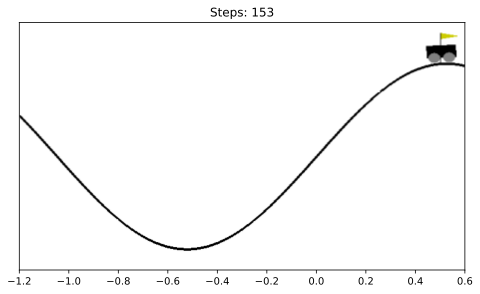

In [35]:
### Let's see our agent in action 🎬

# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from src.viz import show_video

show_video(agent, env, sleep_sec=0.01)

## Plot the policy 🎨

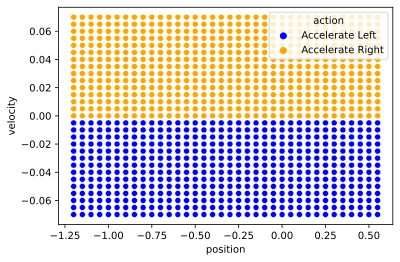

,position,velocity,action
0,-1.20,-0.070,Accelerate Left
1,-1.20,-0.065,Accelerate Left
2,-1.20,-0.060,Accelerate Left
3,-1.20,-0.055,Accelerate Left
4,-1.20,-0.050,Accelerate Left
...,...,...,...
1039,0.55,0.050,Accelerate Right
1040,0.55,0.055,Accelerate Right
1041,0.55,0.060,Accelerate Right
1042,0.55,0.065,Accelerate Right


In [36]:
import numpy as np
from src.viz import plot_policy

positions = np.arange(env.min_position, env.max_position, 0.05)
velocities = np.arange(-env.max_speed, env.max_speed, 0.005)
plot_policy(agent, positions, velocities)

## **SarsaAgent** vs. **MemoneumAgent** 
* overlap only in $50\%$ of the states
* still pretty good perfomance

This means our SarsaAgent is right only 50% of the time.

In [37]:
perfect_action = perfect_policy['action']
sarsa_action = sarsa_policy['action']

print(f'SarsaAgent & MomentumAgent overlaps: {(perfect_action == sarsa_action).sum() / len(perfect_action)}')
#(perfect_action == sarsa_action).sum() / len(perfect_action)

SarsaAgent & MomentumAgent overlaps: 0.553639846743295


### Why  **SarsaAgent** wrong so often but still achieves good performance?

* This is because the ```MountainCar``` is still a small environment, so taking wrong decisions $50\%$ of the time is not so critical. For larger problems, being wrong so often is not enough to build intelligent agents.

  - Would you buy a self-driving car that is right 95% of the time? 😱

* Also, do you remember the ***discretization*** trick we used to apply **SARSA**? That was a trick that helped us a lot but also introduced an error/bias to our solution.

### **curse of dimensionality**

Why don’t we increase the resolution of the discretization for the state and velocity, to get a better solution?

The problem of doing this is the exponential growth in the number of states, also called the **curse of dimensionality**. As you increase the resolution of each state component, the total number of states grows exponentially. The state-space grows too fast for the SARSA agent to converge to the optimal policy in a reasonable amount of time.

## **Policy Optimization**

Ok, but are there any other RL algorithms that can solve this problem perfectly?

Yes, there are. And we will cover them in upcoming lectures. In general, there is no one-size-fits-all when it comes to RL algorithms, so you need to try several of them for your problem to see what works best.

In the ```MountainCar``` environment, the perfect policy looks so simple that we can try to learn it directly, without the need to compute complicated **$q$-value** matrices. A **policy optimization** method will probably work best.

But we are not going to do this today. If you want to solve this environment perfectly using RL, follow along with the course.

Enjoy what you’ve accomplished today.

#6.. Recap ✨
These are the 5 takeaways:

1. **SARSA** is an on-policy algorithm you can use in tabular environments.
2. Small continuous environments can be treated as tabular, using a discretization of the state, and then solved with **tabular SARSA** or **tabular $Q$-learning**.
3. Larger environments cannot be discretized and solved because of the curse of dimensionality.
4. For more complex environments than ```MountainCar``` we will need more advanced RL solutions.
5. **Sometimes RL is not the best solution**. Keep that in mind when you try to solve the problems you care about. Do not marry your tools (in this case RL), instead focus on finding a good solution. Do not miss the forest for the trees 🌲🌲🌲.

#7.. Homework 📚
👉🏽 [04_homework.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/02_mountain_car/notebooks/04_homework.ipynb)

This is what I want you to do:

1. [Git clone](https://github.com/Paulescu/hands-on-rl) the repo to your local machine.
2. [Setup](https://github.com/Paulescu/hands-on-rl/tree/main/02_mountain_car#quick-setup) the environment for this lesson ```02_mountain_car```
3. Open ```02_mountain_car/notebooks/04_homework.ipynb``` and try completing the 2 challenges.

In the first challenge, I ask you to tune the SARSA hyper-parameters ```alpha``` (***learning rate***) and ```gamma``` (***discount factor***) to speed up training. You can get inspiration from [part 2(medium)](https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-2-1b0828a1046b),  [part 2(ivan colab)](https://colab.research.google.com/drive/1Dn2cWuBFIG1rO8h3d92jSqDFiQW5RvLj?usp=sharing).

In the second challenge, try to increase the resolution of the discretization and learn the q-value function with tabular SARSA. As we did today.

Let me know if you build an agent that achieves $99\%$ performance.

As usual, if you get stuck and you need feedback drop me a line at plabartabajo@gmail.com.

++++++++++++++++++++++++++++++++++++++++++ Ivan H.P. Lin (2022/08/01) +++++++++++++